# Retrieve and visualize sweep results
In our setup, each job computes an embedding for a given method and parameter combination in isolation and send the results to wandb. There are plently of ways to visualize the results on the wandb dashbord, for example parallel coordinate plots, which help to understand paramter importance. 

However, the scIB results on wandb don't have the usual min-max column scaling that's frequently used in plots, because such scaling requires all results to be available at once, while each of our jobs only has access to a single run. Here we'll aggregate sweep results from wandb and visualize them jointly with the usual min-max column scaling. 

## Preliminaries

### Library imports

`autoreload` to re-load packages. 

In [1]:
%load_ext autoreload
%autoreload 2

The actual imports. 

In [2]:
import warnings

import matplotlib.pyplot as plt
import rapids_singlecell as rsc
import scanpy as sc
from scembed import scIBAggregator
from scembed.utils import load_embedding

/cluster/project/treutlein/USERS/mlange/miniforge3/envs/scembed/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data

To visualze UMAPs later on, we need to original dataset

In [32]:
adata = sc.read("data/lung_atlas.h5ad", backup_url="https://figshare.com/ndownloader/files/24539942")
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

## Main

### Fetch runs from weights and biases (wandb)

Specify the details of your project first. 

In [18]:
agg = scIBAggregator(entity="spatial_vi", project="scembed_test_2", output_dir="top_results")
agg

INFO     Initialized scIBAggregator for spatial_vi/scembed_test_2                                                  


scIBAggregator(spatial_vi/scembed_test_2, no data fetched)

Now, fetch all runs for this project, across all sweeps. 

In [19]:
agg.fetch_runs()

INFO     Fetching runs from spatial_vi/scembed_test_2...                                                           


Processing runs: 100%|██████████| 24/24 [00:00<00:00, 16998.19it/s]

INFO     Fetched 24 runs                                                                                           
INFO     Available scIB metrics: ['BRAS', 'Graph connectivity', 'KBET', 'KMeans ARI', 'KMeans NMI', 'PCR           
         comparison', 'Silhouette label', 'cLISI', 'iLISI']                                                        
INFO     Processing complete: 7 methods, 0 runs filtered out                                                       


We can now print the object again to get some more info. 

In [20]:
print(agg)

scIBAggregator(spatial_vi/scembed_test_2, 24/24 runs, 7 methods, 9 metrics, output_dir='top_results')


### Inspect individual method

First, let's look at an individual method to understand how different parameters influence performance. Method data is stored in `agg.method_data`: 

In [21]:
agg.method_data.keys()

dict_keys(['precomputed_pca', 'liger', 'scanorama', 'harmony', 'scvi', 'scanvi', 'scpoli'])

Let's take a look at this for `harmony`. 

In [22]:
agg.method_data["harmony"].keys()

dict_keys(['configs', 'scib_benchmarker', 'other_logs'])

The `scib_benchmarker` object can be used just like the regular scIB output: 

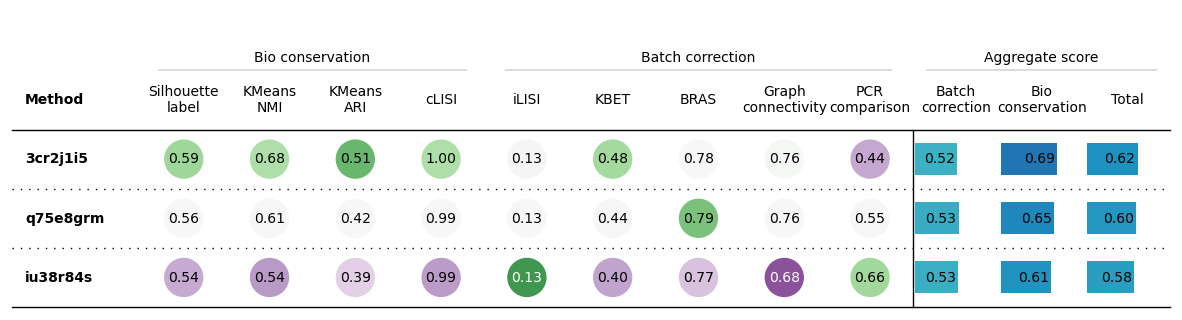

In [23]:
agg.method_data["harmony"]["scib_benchmarker"].plot_results_table(min_max_scale=False)

The differences aren't hughe, but we can still take a look at the corresponding configs. 

In [24]:
agg.method_data["harmony"]["configs"]

,method,embedding_key,k,value_lambda,alpha,sigma,theta,n_latent,n_layers,max_epochs,n_epochs,embedding_dims,pretraining_epochs
run_id,,,,,,,,,,,,,
3cr2j1i5,harmony,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
iu38r84s,harmony,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
q75e8grm,harmony,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN


It looks like `theta=1` works best in this case. 

### Aggregate results across methods

The main thing we want to get out if of course which method workes best on this dataset. For this, we call `.aggregate`, which selects the best performing run per method. 

In [25]:
agg.aggregate()

INFO     Aggregated best runs for 7 methods using metric 'Total'                                                   


Now, there's a `.results` attribute that looks just like the methods above:

In [26]:
agg.results.keys()

dict_keys(['configs', 'scib_benchmarker', 'other_logs'])

Again, the `scib_bencharker` be be used like regular scIB output. 

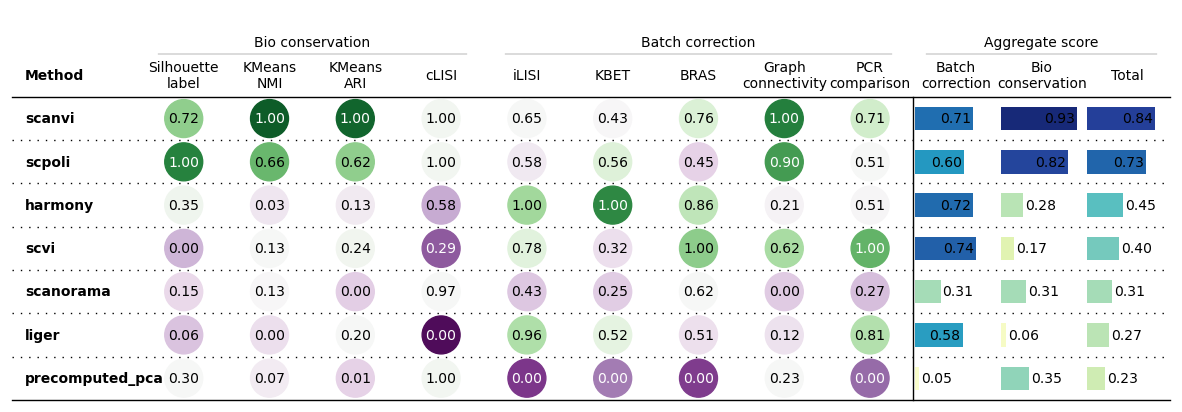

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    agg.results["scib_benchmarker"].plot_results_table(min_max_scale=True)

It looks like we have a clear winner here. Again, we can take a look at the corresponding config for each of these best performing runs. 

In [28]:
agg.results["configs"]

,method,embedding_key,k,value_lambda,alpha,sigma,theta,n_latent,n_layers,max_epochs,n_epochs,embedding_dims,pretraining_epochs,run_id
precomputed_pca,precomputed_pca,X_pca,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,k8iblgi0
liger,liger,NaN,30.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0sqrdct2
scanorama,scanorama,NaN,NaN,NaN,0.3,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mk7ie313
harmony,harmony,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3cr2j1i5
scvi,scvi,NaN,NaN,NaN,NaN,NaN,NaN,30.0,1.0,NaN,NaN,NaN,NaN,ae0ykob8
scanvi,scanvi,NaN,NaN,NaN,NaN,NaN,NaN,10.0,2.0,20.0,NaN,NaN,NaN,gc4k8asd
scpoli,scpoli,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,5.0,40.0,q6g1sbbr


We can also just get the aggregated results dataframe. 

In [29]:
agg.results["scib_benchmarker"].get_results()

,Silhouette label,KMeans NMI,KMeans ARI,cLISI,iLISI,KBET,BRAS,Graph connectivity,PCR comparison,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,,,,
precomputed_pca,0.585415,0.682006,0.476682,1.0,0.008071,0.223213,0.460335,0.764946,0.0,0.291313,0.686026,0.528141
liger,0.548596,0.670398,0.523743,0.992377,0.12526,0.359391,0.646403,0.732332,0.707661,0.514209,0.683779,0.615951
scanorama,0.562559,0.692344,0.473345,0.999734,0.060683,0.287498,0.686382,0.699733,0.234761,0.393812,0.681996,0.566722
harmony,0.592363,0.67637,0.506747,0.996828,0.130154,0.483724,0.777517,0.757674,0.444529,0.518719,0.693077,0.623334
scvi,0.540253,0.693305,0.533738,0.994581,0.10305,0.30633,0.827444,0.872555,0.877159,0.597307,0.690469,0.653205
scanvi,0.648128,0.841636,0.721735,1.0,0.08751,0.334295,0.740992,0.979334,0.618431,0.552112,0.802875,0.70257
scpoli,0.690154,0.784189,0.627898,1.0,0.078726,0.368067,0.624535,0.950023,0.451446,0.494559,0.77556,0.66316
Metric Type,Bio conservation,Bio conservation,Bio conservation,Bio conservation,Batch correction,Batch correction,Batch correction,Batch correction,Batch correction,Aggregate score,Aggregate score,Aggregate score


### Retrieve embeddings

For each best-performing model, let's download the model weights (if available) and the embedding to a local folder. 

In [30]:
agg.get_models_and_embeddings()

wandb:   1 of 1 files downloaded.  


INFO     Downloaded embeddings for method 'precomputed_pca' to top_results/precomputed_pca/                        
WARNING  Missing model for method 'precomputed_pca' (run_id: k8iblgi0)                                             


wandb:   1 of 1 files downloaded.  


INFO     Downloaded embeddings for method 'liger' to top_results/liger/                                            
WARNING  Missing model for method 'liger' (run_id: 0sqrdct2)                                                       


wandb:   1 of 1 files downloaded.  


INFO     Downloaded embeddings for method 'scanorama' to top_results/scanorama/                                    
WARNING  Missing model for method 'scanorama' (run_id: mk7ie313)                                                   


wandb:   1 of 1 files downloaded.  


INFO     Downloaded embeddings for method 'harmony' to top_results/harmony/                                        
WARNING  Missing model for method 'harmony' (run_id: 3cr2j1i5)                                                     


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


INFO     Downloaded models and embeddings for method 'scvi' to top_results/scvi/                                   


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


INFO     Downloaded models and embeddings for method 'scanvi' to top_results/scanvi/                               


wandb:   3 of 3 files downloaded.  
wandb:   1 of 1 files downloaded.  


INFO     Downloaded models and embeddings for method 'scpoli' to top_results/scpoli/                               


Now, we can simply load some of these embeddings, compute UMAPs, and visualize.

In [34]:
keys = ["scanvi", "scpoli", "pca"]

for key in keys:
    adata.obsm[f"X_{key}"] = load_embedding(f"top_results/{key}/embeddings/embedding_{key}.parquet")
    adata.obsm[f"X_{key}"] = adata.obsm[f"X_{key}"].values

    rsc.pp.neighbors(adata, use_rep=f"X_{key}")
    rsc.tl.umap(adata, key_added=f"umap_{key}")

ValueError: File does not exist: top_results/pca/embeddings/embedding_pca.parquet

Now, let's take a look at these. 

In [35]:
fix, axes = plt.subplots(2, len(keys), figsize=(4 * len(keys), 8))


for i, key in enumerate(keys):
    shared_params = {
        "basis": f"umap_{key}",
        "show": False,
        "legend_loc": "right margin" if i == len(keys) - 1 else "none",
    }
    sc.pl.embedding(adata, color="cell_type", ax=axes[0, i], **shared_params)
    sc.pl.embedding(adata, color="batch", ax=axes[1, i], **shared_params)

plt.show()

SyntaxError: closing parenthesis ')' does not match opening parenthesis '{' on line 5 (772461209.py, line 6)

Ok well, there wasn't a strong batch effect here to begin with!